<a href="https://colab.research.google.com/github/morbosohex/Workflow/blob/master/Skip_Gram_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/dl-tensorflow/embeddings")

# Skip-gram word2vec

在本笔记本中，我将引导您使用TensorFlow使用skip-gram架构实现word2vec算法。通过实现这一点，您将学习嵌入用于自然语言处理的单词。在处理机器翻译等事情时，这会派上用场。

## 推荐阅读

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

当你处理文本中的单词时，最终会有数以万计的类来预测，每个单词一个。尝试对这些单词进行单热编码是非常低效的，你将一个元素设置为1而其他元素设置为0.进入第一个隐藏层的矩阵乘法将几乎所有结果值都为零。这极大地浪费了计算量。

![one-hot encodings](assets/one_hot_encoding.png)

为了解决这个问题和提升网络的效率, 我们使用embedding. 嵌入层只是一个全连接层，就像你以前见过的那样。我们将此图层称为嵌入层，权重是嵌入权重。我们跳过到嵌入层的乘法，而是直接从权重矩阵中抓取隐藏的层值. 我们可以这样做，因为独热编码矢量与矩阵的乘法返回矩阵的行，该行对应于输入单元的索引。


![lookup](assets/lookup_matrix.png)

我们使用权重矩阵作为查找表，而不是进行矩阵乘法。我们将单词编码为整数，例如“heart”编码为958，“mind”编码为18094.然后，为了获得“heart”的隐藏层值，您只需取嵌入矩阵的第958行。此过程称为**embedding_lookup**，隐藏单元的数量为**embedding dimension**。

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. 
The embedding lookup table is just a weight matrix. 
The embedding layer is just a hidden layer. 
The lookup is just a shortcut for the matrix multiplication. 
The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

首先，导入包

In [0]:
import time
import numpy as np
import tensorflow as tf
import utils

加载[text8数据集](http://mattmahoney.net/dc/textdata.html)，这是一份来自Matt Mahoney的清理维基百科文章的文件。下一个单元格将数据集下载到`data`文件夹。然后，您可以提取它并删除存档文件以节省存储空间。

In [0]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

# class DLProgress(tqdm):
#     last_block = 0

#     def hook(self, block_num=1, block_size=1, total_size=None):
#         self.total = total_size
#         self.update((block_num - self.last_block) * block_size)
#         self.last_block = block_num

# if not isfile(dataset_filename):
#     with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
#         urlretrieve(
#             'http://mattmahoney.net/dc/text8.zip',
#             dataset_filename,
#             pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## Preprocessing
文本前处理过程，主要功能来自于`utils`, 将标点符号转变为tokens, 将英文句号转变为` <PERIOD>`,在这个数据集中，并没有任何句号，但是该脚本会处理一切其他的NLP问题，我会除去一些出现次数少于5次的词，该操作将会减少一些噪声问题并且提升词向量的质量

![image.png](attachment:image.png)

In [5]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [6]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


在这里，我正在创建字典，将单词转换为整数和之后，再整数转换为单词。整数按降序频率分配，因此最常用的字（“the”）给出整数0，下一个频率为1，依此类推。单词将转换为整数并存储在列表`int_words`中。
![image.png](attachment:image.png)

In [0]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

经常出现的词语如“the”，“of”和“for”并没有为附近的单词提供太多的上下文信息。如果我们丢弃其中一些，我们可以从我们的数据中删除一些噪音，并获得更快的训练和更好的词向量。这个过程被Mikolov称为子采样。对于训练集中的每个单词$w_i$，我们将以给定的概率丢弃它

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

其中$t$是阀值参数，$f(w_i)$是单词$w_i$的在总数据集中的频次


我将把这个留给你作为练习。这更像是一项编程挑战，而不是具体的深度学习。但是，能够为您的网络准备数据是一项重要的技能。看看我的解决方案，看看我是如何做到的。

**练习：**为`int_words`中的单词实现子采样。也就是说，通过`int_words`并丢弃上面给出的可能性$P(w_i)$的每个单词。请注意，$ P(w_i)$是丢弃一个单词的概率。将子采样数据分配给`train_words`。

In [0]:
## Your code here
from collections import Counter
import random

threshold = 1e-5
words_count = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in words_count.items()}
p_drops = {word: 1-np.sqrt(threshold/freqs[word]) for word in words_count}
# random.random是在0-1之间的均匀采样，如果p_drops[word]=0.7，那么random.random()有30%的几率大于0.7，70%几率小于0.7
# 如果舍弃概率小于这个随机生成的数字那么就保留它，否则舍弃该词
train_words = [word for word in int_words if p_drops[word] < random.random()]

## Making batches

现在我们的数据状况良好，我们需要将其转换为适当的形式以将其传递到我们的网络中。使用skip-gram架构，对于文本中的每个单词，我们希望获取围绕该单词的窗口中的所有单词，大小为$C$。

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 
mikolov是在窗口里随机选择一个范围，原因如下
“由于较远的单词通常与当前单词的关联程度低于接近单词的单词，因此需要弱化较远的单词，因此我们通过在训练示例中对这些单词进行较少的抽样来减轻远处单词的权重...如果我们选择$ C = 5 $，对于每个训练单词，我们将在$ <1; C> $范围内随机选择一个数$ R $，这么做相当于你随机在大窗口里选了一个由R定义的小窗口，然后在小窗口里你要以输入单词前和后的R个单词，作为正确的标签，你就总能得到现有单词旁边的单词，至于那些离现有单词较远的词，则获取的概率会比较小“


> **练习：**实现一个函数`get_target`，它接收一个单词列表，一个索引也就是现有单词，和一个窗口大小，然后在索引周围的窗口中返回一个单词列表即窗口里的所有目标单词。确保使用上述算法，从窗口中选择随机数量的单词。

In [0]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    # Your code here
    R = random.randint(1,window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    return list(target_words)

下面的函数是批次返回函数，也就是我们要传递给网络的数据，这个函数会从长长的文本列表，也就是整数列表里，抓取一些单词，然后获取每个单词的目标，也就是应用函数get_targets，换句话说，用上面实现的函数来获取出现在窗口里的目标单词，我还没找到办法把目标单词的这个随机获取范围和Tenssorflow图结合起来，所以这里我就只是，在批次里设置一行一个输入目标对，比如说一个现有单词对应四个目标单词，那我就在批次里将其做成四行，因为由四个输入目标对


In [0]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

输入的单词作为整数传入。这将进入隐藏的线性单元层，然后进入softmax层。我们将使用softmax层进行正常预测。

这里的想法是训练隐藏层权重矩阵，以便为我们的单词找到有效的表示。我们可以丢弃softmax层，因为我们并不真正关心用这个网络进行预测。我们只想要嵌入矩阵，以便我们可以在我们从数据集构建的其他网络中使用它。

我现在要让你分阶段构建图表。首先，创建`inputs`和`labels`占位符

**练习：**使用`tf.placeholder`分配`inputs`和`labels`。我们将传入整数，因此将数据类型设置为`tf.int32`。我们传入的批次将具有不同的大小，因此将批量大小设置为[`None`]。为了使事情能够在以后工作，你需要将`labels`的第二维设置为`None`或`1`。

In [0]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, 1], name='labels')

## Embedding




嵌入矩阵是所有单词的数目乘以隐藏层中的单元数。因此，如果您有10,000个单词和300个隐藏单位，矩阵的大小将为$ 10,000 \ times 300 $。请记住，我们使用标记化数据作为输入，通常作为整数，其中标记的数量是我们词汇表中的单词数。

> **练习：** Tensorflow为我们提供了一个方便的函数[`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup)。传入嵌入矩阵和整数张量，然后返回矩阵中与这些整数对应的行。下面，设置您将使用的嵌入层的维度也即单元数（200是一个好的开始），创建嵌入矩阵变量，并使用`tf.nn.embedding_lookup`来获取嵌入张量。对于嵌入矩阵，我建议您使用[tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform)在-1和1之间使用统一的随机数对其进行初始化。


In [0]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), 
                                               minval=-1,
                                               maxval=1))# create embedding weight matrix here
    embed = tf.nn.embedding_lookup(embedding, inputs)# use tf.nn.embedding_lookup to get the hidden layer output

## Negative sampling



对于我们给网络的每个例子，我们使用softmax层的输出来训练它。这意味着对于每个输入，我们对数百万个权重进行了非常小的更改，即使我们只有一个真实的例子。这使得网络训练效率非常低。我们可以通过仅一次更新所有权重的一小部分来估计softmax层的损失。我们将更新正确标签的权重，但只会更新少量不正确的标签。这被称为[“负采样”](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)。 Tensorflow有一个方便的功能，[`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss)。


> **练习：**下面，为softmax图层创建权重和偏差。然后，使用[`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss)计算损失。请务必阅读文档以了解其工作原理。

In [0]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=1/np.sqrt(n_embedding)))
    
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(weights=softmax_w,
                                      biases=softmax_b,
                                      inputs=embed,
                                      labels=labels,
                                      num_sampled=n_sampled,
                                      num_classes=n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

此代码来自Thushan Ganegedara的实现。在这里，我们将选择几个常用词和几个不常见的词。然后，我们将打印出最接近他们的单词。检查我们的嵌入表是否将具有相似语义含义的单词组合在一起是一种很好的方法。用于跟踪word2vec网络的训练表现

In [14]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

W0902 08:31:43.794833 140319721424768 deprecation.py:506] From <ipython-input-14-2aa168c49a56>:13: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [16]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.5039 0.0325 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.5060 0.0213 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.4141 0.0217 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.5041 0.0211 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.4050 0.0212 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.4244 0.0210 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.4626 0.0210 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.4319 0.0210 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.3393 0.0211 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.2933 0.0204 sec/batch
Nearest to has: venables, cheek, hawks, authentication, acrobatics, pherae, come, schadeberg,
Nearest to years: rinnan, chancellor, tibor, tbm, litigant, hinders, descendants, archaeologically,
Nearest to two: five, democrat, overheating, engineering, loyal, committee, marsalis, blank,
Nearest to h

Restore the trained network if you need to:

In [17]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

W0902 08:48:43.114886 140319721424768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [0]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

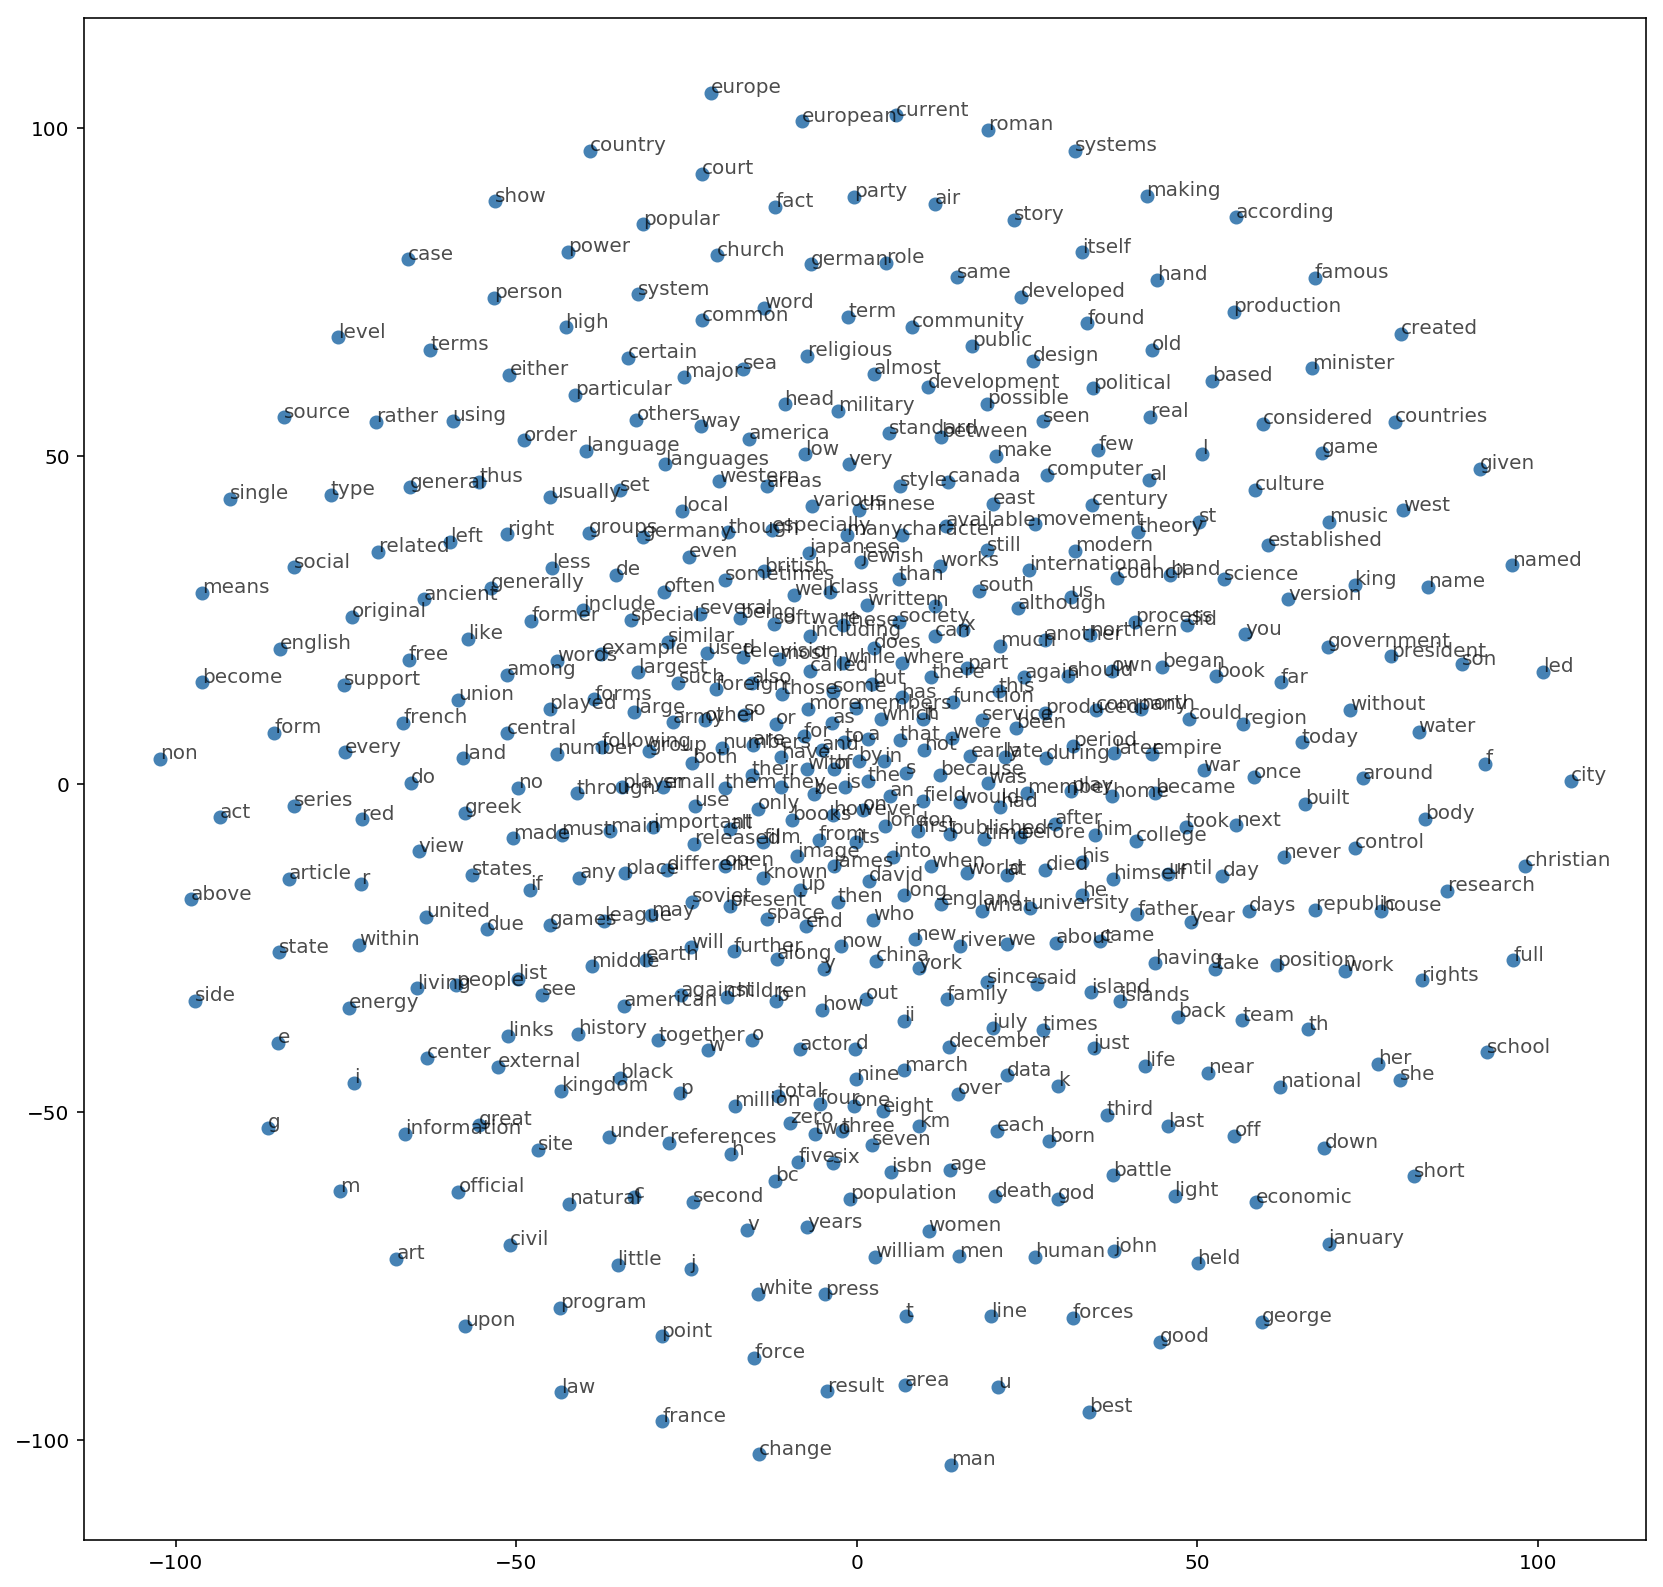

In [20]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)